In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [18]:
def set_seed():
    np.random.seed(20020703)

In [19]:
def simulate_GBM(T,n_steps,X0,sigma):
    """
    Generate Efficient Price Using GBM (BS)
    T: Time Horizon
    n_steps: Number of time steps
    X0: Initial price
    sigma: Volatility
    """
    dt = T / n_steps
    t = np.linspace(0, T, n_steps)
    dW = np.random.normal(0, np.sqrt(dt), n_steps)
    log_X = np.log(X0) - 0.5 * sigma**2 * t + sigma * np.cumsum(dW)
    X = np.exp(log_X)

    return t, X

In [20]:
def simulate_observed_price(X, alpha, eta, L=1):
    
    P = np.zeros_like(X)
    P[0] = np.round(X[0] / alpha) * alpha
    change_indices = [0]

    for i in range(1, len(X)):
        # 使用第一版的阈值计算方式
        upper_threshold = P[i-1] + alpha * (L - 0.5 + eta)
        lower_threshold = P[i-1] - alpha * (L - 0.5 + eta)
        
        # 直接比较有效价格与阈值
        if X[i] >= upper_threshold:
            P[i] = P[i-1] + L * alpha
            change_indices.append(i)
        elif X[i] <= lower_threshold:
            P[i] = P[i-1] - L * alpha
            change_indices.append(i)
        else:
            P[i] = P[i-1]
    
    return  X, P, change_indices

In [38]:
def plot_uncertainty_zone_matplotlib(X,alpha, eta):
    set_seed()
    X, P, change_indices = simulate_observed_price(X,alpha,eta)
    fig, ax = plt.subplots(figsize=(24, 12))

    # Plot Efficient Price and Observed Price
    ax.plot(t, X, label="Efficient Price", color="blue", linewidth=1.5)
    ax.step(t, P, where="post", label="Observed Price", color="red", linestyle="--", linewidth=1.5)

    # Compute mid prices and uncertainty zone boundaries
    mid_prices = np.zeros_like(X)
    lower_bounds = np.zeros_like(X)
    upper_bounds = np.zeros_like(X)
    shaded_lower = np.full_like(X, np.nan)
    shaded_upper = np.full_like(X, np.nan)

    for i in range(len(X)):
        k = np.round(X[i] / alpha)  # Closest tick level
        mid_prices[i] = (k - 0.5) * alpha  # Mid price between two adjacent ticks
        lower_bounds[i] = mid_prices[i] - alpha * (eta)
        upper_bounds[i] = mid_prices[i] + alpha * (eta)

    # Add grid lines at mid prices, lower, and upper bounds
    all_mid_prices = np.unique(mid_prices)
    all_lower_bounds = np.unique(lower_bounds)
    all_upper_bounds = np.unique(upper_bounds)

    # Horizontal grid lines
    for level in all_mid_prices:
        ax.axhline(y=level, color="green", linestyle="-", linewidth=0.5, alpha=1)
    for level in all_lower_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=1)
    for level in all_upper_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=1)

    # Add shaded area for uncertainty zones
    for i in range(len(change_indices) - 1):
        start = change_indices[i]
        end = change_indices[i + 1]
        #mid_price_at_start = mid_prices[start]
        #lower_at_start = mid_price_at_start - alpha * (eta)
        #upper_at_start = mid_price_at_start + alpha * (eta)

        #shaded_lower[start:end] = lower_at_start
        #shaded_upper[start:end] = upper_at_start + alpha

    # Fill shaded area **evenly**
    #ax.fill_between(t, shaded_lower, shaded_upper, color="gray", alpha=0.2)
        mid_price = mid_prices[start]
        lower = mid_price - alpha * eta
        upper = mid_price + alpha * eta+alpha

        # 填充矩形区域（只填充当前 step）
        ax.fill_between(t[start:end+1], lower, upper, color="gray", alpha=0.2, step="post",edgecolor="none")


    # Labels and title
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Price", fontsize=14)
    ax.set_title("Efficient vs Observed Price with Mid Price and Uncertainty Zone Grid", fontsize=16)
    ax.legend(fontsize=12)
    plt.savefig("UncertaintyZone.pdf",format = "pdf")

    # Show plot
    plt.show()

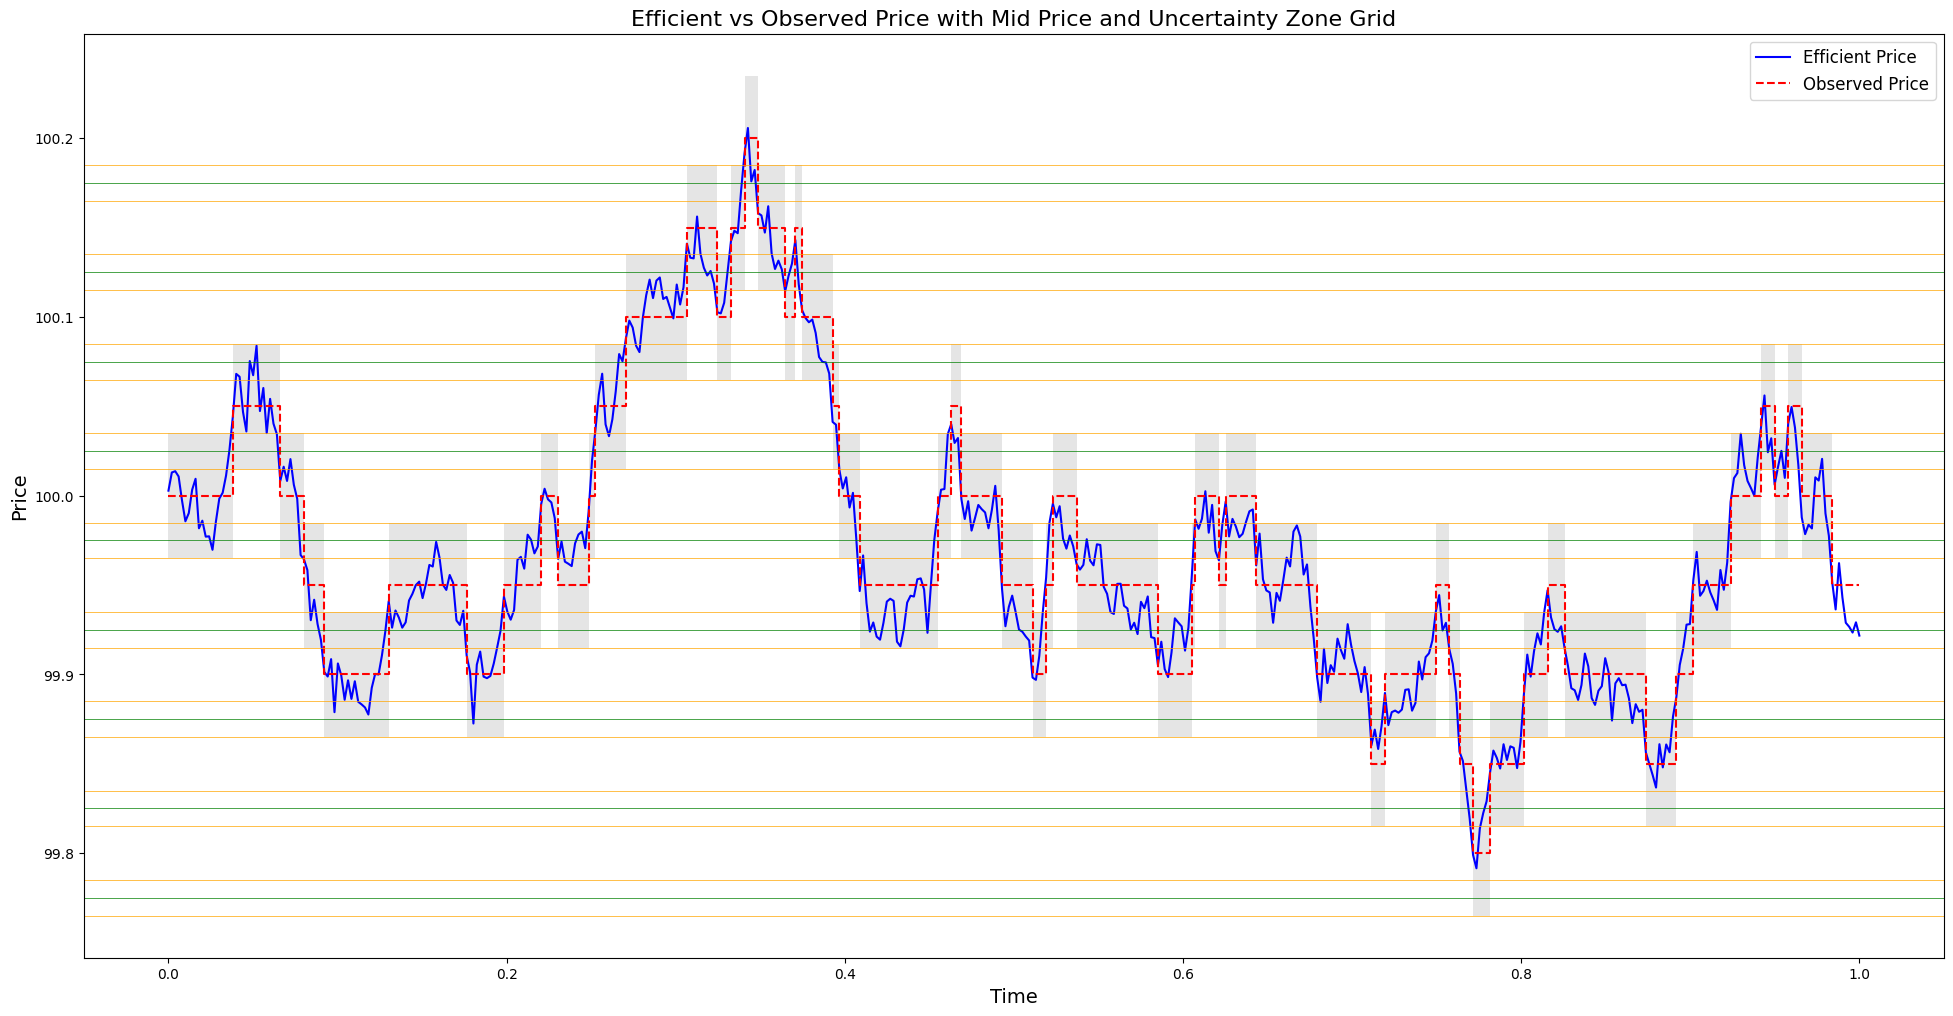

In [40]:
alpha = 0.05      # Tick size
eta = 0.2       # Uncertainty zone width
T = 1.0          # Time horizon
sigma = 0.05/np.sqrt(252)   # Volatility, sigma=0.01  5/np.sqrt(252)
X0 = 100.0       # Initial price
n_steps = 500   # Number of time steps
K = 100 # Strike
number_of_paths = 1000 # For Monto Carlo
t, X = simulate_GBM(T, n_steps, X0, sigma)
plot_uncertainty_zone_matplotlib(X,alpha,eta)

In [23]:
eta = 0.8  # Uncertainty zone width
sigma = 0.01
n_steps = 500

In [24]:
def black_scholes_call(S, K, T, r, sigma):
    """
    Computes the BS price and delta of a European call option.
    """
    if sigma < 0 or T < 0:
        raise ValueError("sigma and T must be greater than zero")
    d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)  
    #print(sigma*np.sqrt(T))
    return call_price, delta

In [25]:
def get_optimal_tau(X, alpha, eta):
    tau = [0]
    l = int(round(alpha**(-0.5)))  # 取最近的整数
    current_zone = (X[0] // alpha) * alpha
    threshold = alpha * (l - 0.5 + eta)
    
    for i in range(1, len(X)):
        upper = current_zone + threshold
        lower = current_zone - threshold
        if X[i] > upper or X[i] < lower:
            tau.append(i)
            current_zone = (X[i] // alpha) * alpha
    return tau

In [26]:
def calculate_hedging_error(t, X, P, tau, K, sigma,use_efficient_price=True):
    """修正后的对冲误差计算函数"""
    T_total = t[-1]
    portfolio = np.zeros(len(tau))
    positions = np.zeros(len(tau))
    calls = np.zeros(len(tau))
    portfolio[0], positions[0] = black_scholes_call(X[tau[0]], K, T - t[tau[0]],0,sigma)

    calls[0] = portfolio[0]
    
    # 动态对冲过程
    for j in range(1, len(tau)):
        if use_efficient_price:
            price_change = X[tau[j]] - X[tau[j-1]]
        else:
            price_change = P[tau[j]] - P[tau[j-1]]
        
        # 更新组合价值
        portfolio[j] = portfolio[j-1] + positions[j-1] * price_change
        

        remaining_T = T_total - t[tau[j]]
        calls[j], positions[j] = black_scholes_call(X[tau[j]], K, remaining_T,0,sigma)
    
    # 计算最终误差
    #final_payoff = max(X[-1] - K, 0)
    #print(portfolio,positions)
    plt.plot(t[tau], portfolio, label = 'Portfolio value at stopping time')
    plt.plot(t[tau], calls, label = 'Call option price at stopping time')

    #return final_payoff - portfolio[-1]
    return calls[-1]-portfolio[-1]

In [27]:
error_1 = np.zeros(number_of_paths)  
error_2 = np.zeros(number_of_paths) 
error_3 = np.zeros(number_of_paths)

In [28]:
def generate_observed_prices(X, tau, alpha):
    """基于退出时间生成观测价格"""
    P = np.zeros_like(X)
    current_p = None
    for i in range(len(X)):
        if i in tau:
            current_p = np.round(X[i] / alpha) * alpha
        P[i] = current_p if current_p is not None else X[0]
    return P

/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_41024/1116294124.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


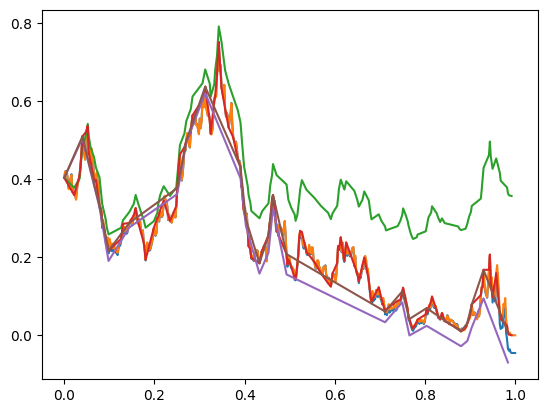

In [29]:
error = np.zeros(1)
for i in range(1):
        t, X = simulate_GBM(T, n_steps, X0, sigma)
        _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta,1)
        #P_fixed1, tau_fixed1 = uncertainty_zone_price(X, alpha, eta, 1)

        tau_optimal = get_optimal_tau(X, alpha, eta)
        #print(tau_optimal)
        #print(tau_optimal)
        tau_ideal = list(range(len(t)))  # 所有时间点

        P_optimal = generate_observed_prices(X, tau_optimal, alpha)
        
        error_1[i] = calculate_hedging_error(t, X, X,tau_ideal, K, sigma)
        error_2[i] = calculate_hedging_error(t, X, P_fixed, tau_fixed, K, sigma,False)
        error_3[i] = calculate_hedging_error(t, X, P_optimal, tau_optimal, K, sigma, False)
        #print(len(tau_fixed))

Processing Paths:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_41024/1116294124.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
Processing Paths:   0%|          | 1/1000 [00:00<01:55,  8.64it/s]

[0, 170, 204]
[0, 120, 365, 485]


Processing Paths:   0%|          | 4/1000 [00:00<02:02,  8.15it/s]

[0, 64, 138, 215, 451]
[0, 62]
[0, 21]
[0, 381]


Processing Paths:   1%|          | 8/1000 [00:00<01:45,  9.38it/s]

[0, 356, 451]
[0, 119, 310]


Processing Paths:   1%|          | 10/1000 [00:01<02:24,  6.85it/s]

[0, 86, 166]
[0, 43, 92, 279]
[0, 46, 206, 238]


Processing Paths:   2%|▏         | 15/1000 [00:01<01:47,  9.18it/s]

[0, 215, 339]
[0, 247, 380, 448]
[0, 392]
[0, 188, 282, 492]


Processing Paths:   2%|▏         | 18/1000 [00:02<01:41,  9.68it/s]

[0, 104, 175]
[0, 203]
[0, 134, 225, 344]
[0]


Processing Paths:   2%|▏         | 21/1000 [00:02<01:49,  8.94it/s]

[0, 412]
[0, 39, 489]
[0, 78]


Processing Paths:   2%|▏         | 24/1000 [00:02<01:54,  8.49it/s]

[0, 164, 311]
[0, 235, 262, 449, 498]


Processing Paths:   3%|▎         | 26/1000 [00:03<01:49,  8.90it/s]

[0, 38, 82, 392]
[0, 142, 352, 497]


Processing Paths:   3%|▎         | 28/1000 [00:03<01:57,  8.30it/s]

[0, 345, 437]
[0, 85, 256, 324]


Processing Paths:   3%|▎         | 31/1000 [00:03<01:47,  9.01it/s]

[0, 118, 221, 303, 379]
[0, 157, 226, 255, 301, 395, 467]
[0, 91, 276]


Processing Paths:   3%|▎         | 33/1000 [00:03<01:46,  9.06it/s]

[0, 102, 263, 356, 446]
[0, 15, 91, 129, 248, 474]
[0, 452]


Processing Paths:   4%|▎         | 35/1000 [00:04<01:50,  8.76it/s]

[0, 200, 400, 485]
[0, 178, 293, 440]


Processing Paths:   4%|▍         | 38/1000 [00:04<01:49,  8.75it/s]

[0, 56, 430]
[0, 426, 467]


Processing Paths:   4%|▍         | 42/1000 [00:04<01:35, 10.06it/s]

[0, 276, 368]
[0, 101]
[0, 126, 411, 465]
[0, 75, 235, 422]


Processing Paths:   4%|▍         | 45/1000 [00:05<01:37,  9.80it/s]

[0, 23, 56, 155, 454, 481]
[0, 55, 163, 329, 375, 467, 478]
[0, 285, 380, 449]


Processing Paths:   5%|▍         | 47/1000 [00:05<01:37,  9.78it/s]

[0, 196, 418, 451]
[0, 309, 455]
[0, 200, 227, 430]


Processing Paths:   5%|▌         | 50/1000 [00:05<01:56,  8.18it/s]

[0, 363, 463]
[0, 96, 200, 386]
[0, 17, 103, 228, 431]
[0, 257]


Processing Paths:   6%|▌         | 55/1000 [00:06<01:36,  9.82it/s]

[0, 67, 323, 394]
[0, 182, 420]
[0, 91, 353, 408]


Processing Paths:   6%|▌         | 58/1000 [00:06<01:35,  9.88it/s]

[0, 119, 421]
[0, 441, 497]
[0, 330, 379, 440]
[0, 41, 120, 217, 345]


Processing Paths:   6%|▋         | 63/1000 [00:07<01:34,  9.89it/s]

[0, 117, 159, 215]
[0, 111, 148, 192, 295, 489]
[0, 331]
[0, 82, 214, 432, 473]


Processing Paths:   7%|▋         | 66/1000 [00:07<01:39,  9.37it/s]

[0, 170]
[0, 15, 442]
[0]
[0, 171, 343, 400]


Processing Paths:   7%|▋         | 69/1000 [00:07<01:43,  9.03it/s]

[0, 129, 273, 346]
[0, 116, 153, 193, 336, 398, 428]


Processing Paths:   7%|▋         | 70/1000 [00:07<01:58,  7.87it/s]

[0, 159]
[0, 88, 119, 145, 263]


Processing Paths:   7%|▋         | 74/1000 [00:08<01:38,  9.45it/s]

[0]
[0, 107, 136, 419, 462]
[0, 191, 258, 321, 462]
[0, 268, 322]


Processing Paths:   8%|▊         | 80/1000 [00:08<01:28, 10.35it/s]

[0, 268]
[0, 371]
[0, 241, 466]
[0, 54, 139, 451]
[0, 92, 218, 245, 496]


Processing Paths:   8%|▊         | 82/1000 [00:09<01:29, 10.21it/s]

[0, 73]
[0, 23, 77, 106, 331]
[0, 110, 315]


Processing Paths:   9%|▊         | 86/1000 [00:09<01:38,  9.27it/s]

[0, 477]
[0, 63, 119, 296, 377]
[0, 138, 246, 269]


Processing Paths:   9%|▉         | 88/1000 [00:09<01:40,  9.05it/s]

[0]
[0, 62, 170, 270]
[0, 58, 154]
[0, 470]


Processing Paths:   9%|▉         | 92/1000 [00:10<01:39,  9.09it/s]

[0, 23, 390]
[0, 180, 331]
[0, 135, 217, 443, 497]


Processing Paths:  10%|▉         | 96/1000 [00:10<01:59,  7.58it/s]

[0, 96, 196]
[0, 38, 147, 295, 445]
[0, 98, 418]


Processing Paths:  10%|▉         | 98/1000 [00:10<01:53,  7.94it/s]

[0, 182, 222, 420, 470]
[0, 191, 288]
[0, 108, 260, 452, 479]


Processing Paths:  10%|█         | 100/1000 [00:11<01:44,  8.58it/s]

[0, 47, 317, 362, 433]
[0, 109, 236, 368]
[0, 312, 434, 476]


Processing Paths:  10%|█         | 104/1000 [00:11<01:36,  9.26it/s]

[0, 152, 322, 359, 430, 468, 490]
[0, 78, 188, 237, 440]
[0, 74, 224, 370]


Processing Paths:  11%|█         | 106/1000 [00:11<01:37,  9.19it/s]

[0, 41, 93, 206, 312]
[0, 148, 265, 317, 413, 498]
[0, 46, 262, 414]


Processing Paths:  11%|█         | 112/1000 [00:13<03:32,  4.18it/s]

[0, 50, 106, 161, 281]
[0, 122]
[0, 418]
[0, 60, 154, 211, 262, 375, 440]


Processing Paths:  11%|█▏        | 114/1000 [00:13<02:38,  5.61it/s]

[0, 85, 313, 364]
[0, 381]
[0, 97, 221, 421]


Processing Paths:  12%|█▏        | 117/1000 [00:13<02:06,  6.98it/s]

[0, 273, 306, 426]
[0, 242]
[0, 105, 314, 397, 449, 465, 480]


Processing Paths:  12%|█▏        | 120/1000 [00:13<01:55,  7.60it/s]

[0, 121, 173, 237, 352, 419]
[0, 149, 268, 311, 473]
[0, 216, 465]
[0, 275]


Processing Paths:  12%|█▏        | 124/1000 [00:14<01:41,  8.60it/s]

[0, 106, 358]
[0, 101, 282, 317, 409]
[0, 119, 163, 442, 483]


Processing Paths:  13%|█▎        | 126/1000 [00:14<01:58,  7.37it/s]

[0, 55, 121, 243, 299]
[0, 223, 299, 359, 441]


Processing Paths:  13%|█▎        | 129/1000 [00:15<01:52,  7.71it/s]

[0, 123, 193, 235, 341]
[0, 100, 326, 482]


Processing Paths:  13%|█▎        | 130/1000 [00:15<01:55,  7.51it/s]

[0, 380]
[0, 128]


Processing Paths:  13%|█▎        | 132/1000 [00:15<02:13,  6.52it/s]

[0]
[0, 219, 259, 367, 475]


Processing Paths:  14%|█▎        | 137/1000 [00:16<01:54,  7.52it/s]

[0, 169, 181, 436]
[0, 296, 380]
[0, 40, 72, 196, 252]
[0, 102, 313, 381]


Processing Paths:  14%|█▍        | 140/1000 [00:16<01:38,  8.77it/s]

[0, 307, 470]
[0, 174, 427, 456]
[0, 131, 165, 203]
[0, 176, 409]


Processing Paths:  14%|█▍        | 144/1000 [00:17<01:41,  8.46it/s]

[0, 192, 314, 433]
[0, 290]
[0, 26, 78, 104, 412]


Processing Paths:  15%|█▍        | 146/1000 [00:17<01:39,  8.59it/s]

[0, 498]
[0, 64, 138, 383, 433]


Processing Paths:  15%|█▍        | 147/1000 [00:17<01:37,  8.72it/s]

[0, 147, 274, 374, 464]
[0, 212, 361]


Processing Paths:  15%|█▌        | 150/1000 [00:17<01:31,  9.33it/s]

[0, 109, 334, 436]
[0, 227, 337]
[0, 424]


Processing Paths:  16%|█▌        | 155/1000 [00:18<01:28,  9.53it/s]

[0, 14, 273, 413]
[0, 225, 237]
[0, 133, 228]
[0, 70, 122, 209]


Processing Paths:  16%|█▌        | 158/1000 [00:18<01:45,  7.99it/s]

[0]
[0, 57, 210, 267, 397]
[0, 28, 70, 327, 387]


Processing Paths:  16%|█▌        | 160/1000 [00:18<01:50,  7.61it/s]

[0, 15, 158]
[0, 292]


Processing Paths:  16%|█▋        | 164/1000 [00:19<01:26,  9.63it/s]

[0, 86, 134, 368, 418, 462]
[0, 83, 199, 348]
[0, 29, 419, 452]
[0, 19, 238, 304, 495]
[0, 222, 289, 393, 437]


Processing Paths:  17%|█▋        | 166/1000 [00:19<01:33,  8.93it/s]

[0, 280, 495]
[0, 460]


Processing Paths:  17%|█▋        | 169/1000 [00:19<01:34,  8.78it/s]

[0, 124, 203]
[0, 72, 315]
[0, 99, 447, 497]
[0, 368, 478]


Processing Paths:  18%|█▊        | 175/1000 [00:20<01:22, 10.05it/s]

[0, 63, 234, 386, 443]
[0, 365]
[0, 46, 113, 161, 342]
[0, 474]


Processing Paths:  18%|█▊        | 177/1000 [00:20<01:41,  8.10it/s]

[0, 44, 146, 319, 386]
[0, 20, 165, 264, 483]
[0, 307, 408, 456]


Processing Paths:  18%|█▊        | 179/1000 [00:21<01:46,  7.68it/s]

[0, 166]
[0, 244]


Processing Paths:  18%|█▊        | 182/1000 [00:21<01:32,  8.83it/s]

[0, 224, 484]
[0, 148, 201, 362, 446]
[0, 88, 317, 353, 444]


Processing Paths:  19%|█▉        | 188/1000 [00:22<01:22,  9.87it/s]

[0, 168, 322]
[0, 49, 218, 370, 440]
[0, 276, 455]
[0, 251]
[0, 62, 117, 255, 302]


Processing Paths:  19%|█▉        | 189/1000 [00:22<01:39,  8.15it/s]

[0, 86]
[0, 58, 114, 195, 384]


Processing Paths:  19%|█▉        | 192/1000 [00:22<01:55,  7.02it/s]

[0, 135, 317, 365, 408]
[0, 86, 298, 404]


Processing Paths:  19%|█▉        | 194/1000 [00:22<01:47,  7.52it/s]

[0, 51, 111, 221, 321, 356]
[0, 224]


Processing Paths:  20%|█▉        | 197/1000 [00:23<01:38,  8.13it/s]

[0, 327, 429]
[0, 200, 268]
[0, 74, 194]


Processing Paths:  20%|██        | 200/1000 [00:23<01:49,  7.27it/s]

[0, 416]
[0, 199, 316, 410]
[0, 415]


Processing Paths:  20%|██        | 201/1000 [00:23<01:59,  6.66it/s]

[0, 107, 175]
[0, 165, 239, 307]


Processing Paths:  20%|██        | 203/1000 [00:24<02:27,  5.40it/s]

[0, 496]
[0, 64, 139, 391, 432]


Processing Paths:  21%|██        | 206/1000 [00:24<02:00,  6.59it/s]

[0, 88]
[0, 87, 155, 343, 473]


Processing Paths:  21%|██        | 208/1000 [00:25<01:54,  6.91it/s]

[0, 234]
[0, 74, 105, 296, 333, 411]


Processing Paths:  21%|██        | 210/1000 [00:25<01:43,  7.62it/s]

[0, 238]
[0, 65, 246, 296, 421, 497]


Processing Paths:  21%|██▏       | 213/1000 [00:25<01:37,  8.11it/s]

[0, 228, 308]
[0, 357]
[0, 31, 94, 187, 242, 291, 401]


Processing Paths:  22%|██▏       | 218/1000 [00:26<01:15, 10.35it/s]

[0, 134, 293, 488]
[0, 87, 127, 398]
[0, 121, 282]
[0, 120, 411]
[0, 76, 217, 474]


Processing Paths:  22%|██▏       | 220/1000 [00:26<01:21,  9.55it/s]

[0, 144, 437]
[0, 152, 492]


Processing Paths:  22%|██▏       | 222/1000 [00:26<01:22,  9.38it/s]

[0]
[0, 137, 358]
[0, 78, 132, 476]


Processing Paths:  22%|██▎       | 225/1000 [00:26<01:17,  9.96it/s]

[0, 40, 113, 190, 325, 406, 455]
[0, 269, 449]
[0, 110, 296]


Processing Paths:  23%|██▎       | 229/1000 [00:27<01:12, 10.69it/s]

[0]
[0, 183]
[0, 219, 369, 414]
[0, 163, 326, 406, 444]


Processing Paths:  23%|██▎       | 232/1000 [00:27<01:30,  8.51it/s]

[0, 162]
[0, 313, 457]
[0, 86, 439]


Processing Paths:  24%|██▎       | 236/1000 [00:28<01:25,  8.95it/s]

[0, 58, 360, 468]
[0, 211]
[0, 49, 340, 429]


Processing Paths:  24%|██▍       | 238/1000 [00:28<01:27,  8.72it/s]

[0, 265, 303]
[0, 208, 252, 485]
[0, 77, 120, 208, 261, 275]


Processing Paths:  24%|██▍       | 240/1000 [00:28<02:26,  5.19it/s]

[0, 61, 256, 347, 457]
[0, 257, 321, 429, 473]


Processing Paths:  24%|██▍       | 244/1000 [00:29<01:32,  8.15it/s]

[0, 144, 417]
[0, 272, 438]
[0, 139, 359]
[0, 81, 164, 450]


Processing Paths:  25%|██▍       | 248/1000 [00:29<01:31,  8.26it/s]

[0, 318]
[0, 128, 485]
[0, 115, 391]


Processing Paths:  25%|██▌       | 250/1000 [00:30<01:49,  6.85it/s]

[0, 49, 92, 174, 242, 390, 473]
[0, 221, 316, 481]


Processing Paths:  25%|██▌       | 252/1000 [00:30<01:39,  7.55it/s]

[0, 382, 490]
[0, 60, 492]
[0, 220]


Processing Paths:  26%|██▌       | 257/1000 [00:30<01:20,  9.19it/s]

[0]
[0, 76, 327]
[0, 25, 54, 294, 497]
[0]


Processing Paths:  26%|██▌       | 258/1000 [00:30<01:28,  8.39it/s]

[0, 148, 302]
[0, 122, 214]


Processing Paths:  26%|██▌       | 262/1000 [00:31<01:25,  8.60it/s]

[0, 279]
[0, 87, 127, 330, 375, 433]
[0, 40, 164, 232, 356]


Processing Paths:  27%|██▋       | 266/1000 [00:31<01:13, 10.04it/s]

[0, 251, 309]
[0, 245, 319]
[0]
[0, 179, 293, 320, 383]


Processing Paths:  27%|██▋       | 270/1000 [00:32<01:13,  9.94it/s]

[0, 122, 426]
[0, 116, 272, 416]
[0, 196, 368]
[0, 221]


Processing Paths:  27%|██▋       | 272/1000 [00:32<01:21,  8.98it/s]

[0, 85, 424]
[0, 56, 105, 321, 366]
[0, 82, 192, 359]
[0, 136]


Processing Paths:  28%|██▊       | 277/1000 [00:32<01:14,  9.70it/s]

[0, 493]
[0, 131, 220, 275, 302, 378, 458]
[0, 46, 214, 270, 360, 425, 463]


Processing Paths:  28%|██▊       | 283/1000 [00:33<01:08, 10.51it/s]

[0, 169, 267]
[0, 440]
[0, 38, 362]
[0, 41, 96]
[0, 486]
[0, 54, 111, 190, 379, 440]


Processing Paths:  29%|██▉       | 289/1000 [00:33<01:04, 11.00it/s]

[0, 218, 459]
[0, 69, 179]
[0, 101, 202, 479]
[0, 222, 332, 472]
[0, 43]
[0, 75, 148, 379]


Processing Paths:  30%|██▉       | 295/1000 [00:34<01:15,  9.34it/s]

[0, 250, 413, 484]
[0, 96, 298, 393]
[0, 284]
[0, 208, 299, 472]
[0, 85, 136, 364]
[0, 104, 181, 253, 276, 417]


Processing Paths:  30%|██▉       | 299/1000 [00:35<01:07, 10.34it/s]

[0, 407]
[0]
[0, 70, 127, 214, 310, 442]
[0, 406, 497]


Processing Paths:  30%|███       | 303/1000 [00:35<01:08, 10.16it/s]

[0, 66, 170, 387]
[0]
[0, 28, 142, 221]
[0, 447]
[0, 409]


Processing Paths:  31%|███       | 307/1000 [00:35<01:04, 10.80it/s]

[0, 158, 238, 349, 491]
[0, 68, 114, 269, 481]
[0, 208, 423]
[0, 35, 186, 299, 426]


Processing Paths:  31%|███▏      | 313/1000 [00:36<00:59, 11.64it/s]

[0, 105, 328, 399]
[0, 47, 128, 320, 438]
[0, 81, 121, 177, 364]
[0, 89, 144, 469]
[0, 486]


Processing Paths:  32%|███▏      | 315/1000 [00:36<00:57, 11.85it/s]

[0, 114, 198, 283]
[0, 18, 56, 231, 239, 309]
[0, 79]
[0, 186]


Processing Paths:  32%|███▏      | 321/1000 [00:36<01:02, 10.78it/s]

[0, 239, 460]
[0]
[0, 63, 450]
[0, 83, 384, 489]


Processing Paths:  33%|███▎      | 327/1000 [00:37<00:57, 11.79it/s]

[0, 167, 412, 476]
[0, 116, 200, 238, 455, 499]
[0, 431]
[0, 210, 312, 397]
[0, 177, 272, 371]
[0, 134, 256, 294]


Processing Paths:  33%|███▎      | 331/1000 [00:37<00:55, 12.09it/s]

[0, 40, 119, 158, 315, 435]
[0, 121, 285, 473]
[0, 159, 245, 478]
[0, 186]


Processing Paths:  34%|███▎      | 335/1000 [00:38<00:54, 12.19it/s]

[0, 271, 484]
[0, 342, 405]
[0, 201, 223]
[0, 33, 74]
[0, 268, 382, 488]


Processing Paths:  34%|███▍      | 341/1000 [00:38<00:53, 12.27it/s]

[0, 83, 403, 465]
[0, 125, 148, 256, 287, 439]
[0, 113, 221, 255]
[0, 28, 366]
[0]


Processing Paths:  34%|███▍      | 345/1000 [00:38<00:52, 12.43it/s]

[0, 175, 499]
[0, 402]
[0, 170, 473]
[0, 201, 231, 351]
[0, 57, 141, 222, 482]


Processing Paths:  35%|███▍      | 349/1000 [00:39<00:51, 12.57it/s]

[0, 135, 202]
[0, 180, 447]
[0, 175, 322, 399, 466]
[0, 130]


Processing Paths:  36%|███▌      | 355/1000 [00:39<00:51, 12.52it/s]

[0, 91, 239, 301, 372]
[0, 161]
[0, 82, 169, 226, 354, 423]
[0, 398, 481]
[0, 181, 325, 343, 471]


Processing Paths:  36%|███▌      | 361/1000 [00:40<00:51, 12.44it/s]

[0, 180, 423]
[0, 355, 395]
[0, 193, 430]
[0, 274, 375]
[0, 135, 157, 379]
[0, 258, 291, 476]


Processing Paths:  36%|███▋      | 365/1000 [00:40<00:50, 12.59it/s]

[0, 134, 336]
[0, 102, 180, 379]
[0, 167, 406]
[0, 58, 146, 184, 209, 294, 321, 376, 437]
[0, 37, 311, 354]


Processing Paths:  37%|███▋      | 369/1000 [00:40<00:53, 11.77it/s]

[0, 230, 285]
[0]
[0, 135, 435]
[0, 112, 168, 353]
[0, 78, 151, 213]


Processing Paths:  38%|███▊      | 375/1000 [00:41<00:52, 12.02it/s]

[0, 248]
[0, 32, 246, 422]
[0, 48, 168, 295, 351, 473]
[0, 406]


Processing Paths:  38%|███▊      | 377/1000 [00:41<00:50, 12.23it/s]

[0, 139, 336, 408]
[0, 231, 496]
[0, 23, 297, 440]
[0, 49, 108, 252, 291, 489]


Processing Paths:  38%|███▊      | 383/1000 [00:42<00:54, 11.22it/s]

[0]
[0, 343]
[0, 49, 114, 347]
[0, 67, 150, 179, 208, 270]
[0, 298]
[0, 68, 318]


Processing Paths:  39%|███▊      | 386/1000 [00:42<01:10,  8.70it/s]

[0, 221, 351, 470]
[0]


Processing Paths:  39%|███▉      | 388/1000 [00:42<01:13,  8.30it/s]

[0, 149, 212, 306, 345, 415]
[0, 338]


Processing Paths:  39%|███▉      | 392/1000 [00:43<00:58, 10.33it/s]

[0, 312, 406]
[0]
[0, 147, 414]
[0, 46, 130, 410]


Processing Paths:  40%|███▉      | 398/1000 [00:43<00:52, 11.56it/s]

[0, 149]
[0, 278, 326, 415]
[0, 337, 457]
[0, 252]
[0, 99, 263, 293]


Processing Paths:  40%|████      | 400/1000 [00:43<00:51, 11.74it/s]

[0, 80, 134, 315]
[0, 23, 232, 261, 384]
[0, 142, 177, 247, 458]
[0, 119, 277, 448]


Processing Paths:  41%|████      | 406/1000 [00:44<00:48, 12.32it/s]

[0, 24, 248, 432]
[0, 119, 274]
[0, 191]
[0, 268, 401]


Processing Paths:  41%|████      | 412/1000 [00:44<00:51, 11.53it/s]

[0, 82, 484]
[0, 75, 142, 322, 415, 491]
[0, 138, 450]
[0, 33, 390, 498]
[0, 209, 269, 297]
[0, 58, 81, 236, 442]


Processing Paths:  42%|████▏     | 416/1000 [00:45<00:49, 11.85it/s]

[0, 372, 432]
[0, 87, 285]
[0, 302, 391, 461]
[0, 254]


Processing Paths:  42%|████▏     | 422/1000 [00:45<00:48, 11.87it/s]

[0, 349]
[0, 191, 287]
[0, 54, 72, 345, 373]
[0, 35, 189]
[0, 80, 120, 265, 342, 428]
[0, 311]


Processing Paths:  43%|████▎     | 428/1000 [00:46<00:46, 12.27it/s]

[0, 89, 147]
[0, 83, 192, 322]
[0, 138]
[0, 214]
[0, 84, 110]
[0, 112, 293, 471]


Processing Paths:  43%|████▎     | 432/1000 [00:46<00:45, 12.48it/s]

[0, 82, 174]
[0, 191, 412]
[0, 261, 496]
[0, 132, 223, 461]


Processing Paths:  44%|████▎     | 436/1000 [00:46<00:45, 12.38it/s]

[0, 92]
[0, 158, 302, 341, 381]
[0, 462, 489]
[0, 301, 352]


Processing Paths:  44%|████▍     | 440/1000 [00:47<00:44, 12.51it/s]

[0, 96, 193, 400]
[0, 217, 270, 324]
[0, 87, 216]
[0, 34, 166, 196, 257, 288, 312, 343]


Processing Paths:  44%|████▍     | 444/1000 [00:47<00:51, 10.72it/s]

[0, 318, 427]
[0, 29, 290, 388, 467]
[0, 60, 229, 344]
[0, 203, 284, 404]
[0, 82, 169, 312, 346]
[0, 76, 186, 292, 426]


Processing Paths:  45%|████▍     | 448/1000 [00:47<00:51, 10.73it/s]

[0, 63, 148, 239, 490]
[0]


Processing Paths:  45%|████▌     | 450/1000 [00:48<00:49, 11.02it/s]

[0, 178]
[0, 44, 119, 247, 316, 455]
[0, 292, 367]


Processing Paths:  45%|████▌     | 454/1000 [00:48<00:47, 11.48it/s]

[0, 112, 127, 458]
[0, 89, 151, 227, 292, 318]
[0, 122, 237, 372, 482]
[0, 98, 366, 443]


Processing Paths:  46%|████▌     | 456/1000 [00:48<00:47, 11.41it/s]

[0, 68, 100, 146, 212]
[0]
[0, 391, 444]


Processing Paths:  46%|████▌     | 462/1000 [00:49<00:44, 12.03it/s]

[0, 171, 469]
[0, 153, 437]
[0, 152, 315, 371]
[0, 63, 144, 291]
[0, 195, 393]
[0]


Processing Paths:  47%|████▋     | 468/1000 [00:49<00:43, 12.33it/s]

[0, 96, 190, 490]
[0, 179, 231, 423]
[0, 297]
[0, 218, 299, 360, 446]


Processing Paths:  47%|████▋     | 472/1000 [00:49<00:42, 12.53it/s]

[0, 281, 455]
[0, 116, 180, 330, 460]
[0, 94, 129, 274]
[0, 343]


Processing Paths:  48%|████▊     | 476/1000 [00:50<00:41, 12.65it/s]

[0, 90]
[0, 352]
[0, 98, 204]
[0, 75, 100, 145, 194, 240, 477]
[0, 330, 399]
[0, 100, 142]


Processing Paths:  48%|████▊     | 482/1000 [00:50<00:40, 12.85it/s]

[0, 66, 158, 332]
[0, 39, 203, 481]
[0, 452]
[0, 60, 104, 134, 182, 228, 328, 476]


Processing Paths:  49%|████▊     | 486/1000 [00:50<00:39, 12.93it/s]

[0, 70, 116, 331]
[0, 239, 389]
[0, 181, 251, 423, 487]
[0, 66, 201, 238, 340, 448]
[0, 195, 248]


Processing Paths:  49%|████▉     | 488/1000 [00:51<00:39, 12.83it/s]

[0, 69]
[0, 318]
[0, 30, 52, 349, 389]


Processing Paths:  49%|████▉     | 492/1000 [00:51<00:45, 11.19it/s]

[0, 178, 314]
[0, 104, 267]
[0, 80, 166, 365, 483]


Processing Paths:  50%|████▉     | 496/1000 [00:51<00:42, 11.82it/s]

[0, 73, 402]
[0, 111, 231, 320]
[0, 108, 272, 400]


Processing Paths:  50%|█████     | 500/1000 [00:52<00:40, 12.30it/s]

[0]
[0, 142, 293, 383, 441]
[0, 90, 177, 347]
[0, 79, 114, 189, 257, 447]


Processing Paths:  51%|█████     | 506/1000 [00:52<00:39, 12.54it/s]

[0, 137, 172, 463]
[0, 119, 345]
[0, 81, 100, 458]
[0, 253]
[0, 74, 157, 218]
[0, 243, 304, 378]


Processing Paths:  51%|█████     | 510/1000 [00:52<00:39, 12.50it/s]

[0, 35, 150, 319, 429]
[0, 95, 177, 289, 366]
[0, 109, 265]
[0, 375]
[0, 239, 312]
[0, 361, 434]


Processing Paths:  52%|█████▏    | 516/1000 [00:53<00:38, 12.53it/s]

[0, 460]
[0, 264, 329]
[0]
[0, 203, 238, 427]


Processing Paths:  52%|█████▏    | 520/1000 [00:53<00:38, 12.51it/s]

[0, 114, 221, 235, 421, 467]
[0, 435, 481]
[0, 117, 449]
[0, 105, 210, 315, 368, 480]


Processing Paths:  52%|█████▏    | 524/1000 [00:54<00:38, 12.28it/s]

[0, 163, 179, 391, 426]
[0, 174, 239, 425]
[0, 134, 213, 373, 470]
[0, 64, 115]


Processing Paths:  53%|█████▎    | 528/1000 [00:54<00:41, 11.25it/s]

[0, 231, 269, 308, 462]
[0, 176, 279]
[0, 83, 237, 254, 332, 494]
[0, 44, 67, 232, 261]


Processing Paths:  53%|█████▎    | 534/1000 [00:54<00:40, 11.43it/s]

[0, 135, 189]
[0]
[0, 134, 252, 498]
[0, 308, 421]
[0, 196, 327]
[0, 208, 295, 485]


Processing Paths:  54%|█████▍    | 540/1000 [00:55<00:37, 12.19it/s]

[0, 58, 174, 251, 302, 396]
[0, 449, 482]
[0, 205, 370]
[0, 36, 227, 394]
[0, 286, 320, 385]
[0, 84, 155]


Processing Paths:  54%|█████▍    | 544/1000 [00:55<00:36, 12.50it/s]

[0, 206, 449]
[0, 124, 153, 288, 401, 424, 490]
[0, 272]
[0, 312, 401, 450]


Processing Paths:  55%|█████▌    | 550/1000 [00:56<00:35, 12.53it/s]

[0, 169, 317]
[0, 231, 319, 449]
[0, 114, 259, 333, 364, 422]
[0, 323, 484]
[0, 47, 123, 456, 481]
[0]


Processing Paths:  55%|█████▌    | 554/1000 [00:56<00:35, 12.49it/s]

[0, 89, 254, 307, 407]
[0, 309, 365]
[0, 57, 202, 271]
[0, 456]
[0, 39, 230, 288, 370]
[0, 427]


Processing Paths:  56%|█████▌    | 560/1000 [00:57<00:35, 12.51it/s]

[0, 479, 498]
[0, 50, 139, 437]
[0, 66, 119, 157]
[0, 38, 96, 137, 390]


Processing Paths:  56%|█████▋    | 564/1000 [00:57<00:35, 12.26it/s]

[0, 183]
[0, 169, 236, 317, 453]
[0, 216, 330]
[0, 357, 392, 478]
[0, 347]
[0]


Processing Paths:  57%|█████▋    | 570/1000 [00:57<00:34, 12.55it/s]

[0]
[0, 244, 405]
[0, 55, 291, 396, 443, 482]
[0, 172]


Processing Paths:  57%|█████▋    | 574/1000 [00:58<00:37, 11.25it/s]

[0, 180, 215, 268, 352]
[0, 26, 226]
[0, 452]
[0, 325]


Processing Paths:  58%|█████▊    | 576/1000 [00:58<00:36, 11.61it/s]

[0, 137, 432]
[0, 194, 321]
[0, 238, 321, 415]


Processing Paths:  58%|█████▊    | 580/1000 [00:58<00:34, 12.08it/s]

[0, 162]
[0]
[0, 160, 214]
[0, 77, 204, 291, 368, 430]


Processing Paths:  58%|█████▊    | 582/1000 [00:58<00:34, 12.17it/s]

[0, 57, 287, 460]
[0, 27, 263, 486]
[0, 352]


Processing Paths:  59%|█████▊    | 586/1000 [00:59<00:33, 12.33it/s]

[0, 279, 331]
[0, 118, 312, 471]
[0, 35, 69, 247, 268, 303]
[0, 157, 448]


Processing Paths:  59%|█████▉    | 592/1000 [00:59<00:32, 12.44it/s]

[0, 45, 127, 291, 459]
[0, 46, 249, 340]
[0, 95]
[0, 41, 109, 322, 418]


Processing Paths:  60%|█████▉    | 596/1000 [01:00<00:32, 12.29it/s]

[0, 27, 373]
[0, 453]
[0, 177, 430]
[0, 150, 197, 231, 304]


Processing Paths:  60%|█████▉    | 598/1000 [01:00<00:34, 11.54it/s]

[0, 54, 304, 355, 408]
[0, 108, 133, 180, 292, 391, 460]
[0, 164, 176]


Processing Paths:  60%|██████    | 602/1000 [01:00<00:46,  8.47it/s]

[0, 260, 370]
[0, 178, 303]
[0, 104, 243, 486]


Processing Paths:  61%|██████    | 606/1000 [01:01<00:38, 10.16it/s]

[0, 463]
[0, 101, 240, 423]
[0, 127, 291, 351]
[0, 73, 407, 475]


Processing Paths:  61%|██████    | 612/1000 [01:01<00:34, 11.32it/s]

[0]
[0, 367]
[0, 400]
[0, 324]
[0, 369, 495]
[0, 290]


Processing Paths:  62%|██████▏   | 616/1000 [01:01<00:32, 11.92it/s]

[0, 32, 289]
[0, 39, 124, 253]
[0, 280, 360]
[0, 68, 178, 496]


Processing Paths:  62%|██████▏   | 622/1000 [01:02<00:31, 12.11it/s]

[0, 140, 348]
[0, 263, 335, 491]
[0, 252, 359]
[0, 46, 238, 301, 427]
[0, 19, 284, 429, 490]
[0]


Processing Paths:  63%|██████▎   | 626/1000 [01:02<00:30, 12.22it/s]

[0, 171, 226]
[0, 110, 255, 409, 496]
[0, 55, 163, 215, 296]
[0, 108, 124, 172, 289]
[0, 440]


Processing Paths:  63%|██████▎   | 628/1000 [01:02<00:30, 12.35it/s]

[0, 330, 457]
[0]
[0, 219, 452]


Processing Paths:  63%|██████▎   | 634/1000 [01:03<00:30, 11.96it/s]

[0, 54, 269, 286]
[0, 73, 147, 267, 342, 472]
[0, 221]
[0, 184, 369, 459]


Processing Paths:  64%|██████▍   | 640/1000 [01:03<00:29, 12.33it/s]

[0, 44, 126, 156, 173, 252]
[0, 378, 435, 485]
[0, 127, 314, 461]
[0, 161, 223, 426]
[0, 123]
[0, 60, 93, 393]


Processing Paths:  65%|██████▍   | 646/1000 [01:04<00:29, 11.90it/s]

[0, 257, 302, 385, 417, 490]
[0, 177, 386]
[0, 27, 165, 191]
[0, 16, 337, 416, 473]
[0, 187]
[0, 40, 447]


Processing Paths:  65%|██████▌   | 650/1000 [01:04<00:28, 12.20it/s]

[0, 155, 237, 340]
[0, 235, 247, 280, 486]
[0, 38, 233, 285]
[0, 39, 138, 194]


Processing Paths:  65%|██████▌   | 654/1000 [01:05<00:27, 12.42it/s]

[0, 50, 106, 449]
[0, 167, 305, 385]
[0, 107, 221, 264, 479]
[0, 96, 459]
[0, 167]


Processing Paths:  66%|██████▌   | 658/1000 [01:05<00:27, 12.62it/s]

[0]
[0, 187]
[0, 42, 133, 204, 395]
[0, 133, 263, 319, 457]
[0, 232, 321, 382, 433]


Processing Paths:  66%|██████▋   | 664/1000 [01:05<00:26, 12.67it/s]

[0, 95, 118, 380]
[0, 276, 411]
[0, 211]
[0, 119, 138, 212, 324, 424, 480]


Processing Paths:  67%|██████▋   | 670/1000 [01:06<00:26, 12.57it/s]

[0, 76, 191, 491]
[0, 43, 211, 325, 418]
[0, 32, 100, 200]
[0, 135, 150, 267, 481]
[0, 64, 469]
[0, 73, 415]


Processing Paths:  67%|██████▋   | 674/1000 [01:06<00:26, 12.41it/s]

[0]
[0, 150, 330, 375]
[0, 228, 260]
[0, 395, 490]


Processing Paths:  68%|██████▊   | 676/1000 [01:06<00:30, 10.73it/s]

[0, 167, 239, 396, 440]
[0, 403, 466]
[0, 212, 252, 497]


Processing Paths:  68%|██████▊   | 682/1000 [01:07<00:27, 11.58it/s]

[0, 128, 417]
[0]
[0, 71, 171, 464]
[0, 53, 473]
[0, 86, 222, 307, 439]
[0, 82, 198, 386]


Processing Paths:  69%|██████▉   | 688/1000 [01:07<00:25, 12.16it/s]

[0, 61, 101, 200, 333, 361]
[0]
[0, 44, 185, 448]
[0]
[0, 80, 184, 452]
[0, 125, 181, 257, 477]


Processing Paths:  69%|██████▉   | 692/1000 [01:08<00:25, 12.26it/s]

[0, 34, 203]
[0, 422]
[0, 243, 337]
[0, 34, 182, 210, 316]


Processing Paths:  70%|██████▉   | 696/1000 [01:08<00:24, 12.48it/s]

[0, 61, 242, 393, 458]
[0, 44, 218, 255, 448]
[0, 59, 192, 232, 430]
[0, 114, 336]
[0, 36, 262]


Processing Paths:  70%|███████   | 700/1000 [01:08<00:23, 12.70it/s]

[0, 104]
[0, 82, 179, 310, 359]
[0, 421]


Processing Paths:  70%|███████   | 704/1000 [01:09<00:23, 12.77it/s]

[0, 109, 229]
[0, 491]
[0, 92, 131, 230, 371]
[0, 107, 208, 354, 449]


Processing Paths:  71%|███████   | 708/1000 [01:09<00:22, 12.75it/s]

[0, 271, 358, 377]
[0, 231, 362, 403]
[0, 85, 159]
[0, 399]


Processing Paths:  71%|███████▏  | 714/1000 [01:10<00:23, 12.41it/s]

[0, 211, 406]
[0, 21, 178, 304]
[0, 184, 376, 479]
[0, 115, 252, 303, 424, 450]
[0]


Processing Paths:  72%|███████▏  | 718/1000 [01:10<00:23, 12.23it/s]

[0, 333, 458]
[0, 107, 321]
[0, 162, 196, 371, 398, 452, 475]
[0, 179, 274, 424, 447]


Processing Paths:  72%|███████▏  | 722/1000 [01:10<00:22, 12.32it/s]

[0, 213]
[0, 46, 255, 295]
[0, 90, 167, 238, 473]
[0, 117, 231, 322]


Processing Paths:  72%|███████▏  | 724/1000 [01:10<00:25, 10.98it/s]

[0, 99, 197, 246, 381]
[0, 64, 273]
[0, 156, 345]


Processing Paths:  73%|███████▎  | 730/1000 [01:11<00:22, 11.98it/s]

[0, 178, 277]
[0, 39, 134, 159, 371, 467]
[0, 186, 209, 327, 380, 407, 468]
[0, 274, 494]
[0, 236, 369, 421]


Processing Paths:  73%|███████▎  | 734/1000 [01:11<00:21, 12.32it/s]

[0, 73, 245, 339]
[0, 383, 479]
[0, 326]
[0, 64, 345, 467]


Processing Paths:  74%|███████▍  | 738/1000 [01:12<00:21, 12.48it/s]

[0, 147, 230, 488]
[0, 107, 222, 456]
[0, 405]
[0, 96, 200]
[0, 90, 250, 350, 414, 492]


Processing Paths:  74%|███████▍  | 742/1000 [01:12<00:20, 12.39it/s]

[0]
[0, 40, 129, 394]
[0, 168, 274, 472]
[0, 97]
[0, 417]


Processing Paths:  75%|███████▍  | 746/1000 [01:12<00:20, 12.39it/s]

[0, 98, 309]
[0, 127, 231, 332]
[0, 205, 274, 391]


Processing Paths:  75%|███████▌  | 750/1000 [01:13<00:20, 12.03it/s]

[0, 34, 56, 133, 299]
[0, 134, 318, 442]
[0, 37, 84, 181, 193, 251, 471]
[0, 50, 235]
[0, 60, 189, 355, 389, 423, 458]


Processing Paths:  76%|███████▌  | 756/1000 [01:13<00:19, 12.41it/s]

[0, 366]
[0, 97, 249, 384, 496]
[0, 40, 206, 238, 281, 310]
[0, 225, 453, 480]


Processing Paths:  76%|███████▌  | 762/1000 [01:13<00:19, 12.07it/s]

[0, 200, 445, 493]
[0, 72]
[0, 61, 210, 391, 464]
[0, 327, 474]
[0, 134, 278, 339, 430]
[0, 241, 361, 425]


Processing Paths:  77%|███████▋  | 766/1000 [01:14<00:19, 12.21it/s]

[0, 95, 429]
[0, 123, 294, 447]
[0, 177, 229, 336, 484]
[0, 162, 445]


Processing Paths:  77%|███████▋  | 770/1000 [01:14<00:18, 12.31it/s]

[0, 127, 298]
[0, 13, 248, 414]
[0, 214, 336, 469]
[0, 101]
[0, 43, 58, 171, 271]


Processing Paths:  77%|███████▋  | 772/1000 [01:14<00:21, 10.81it/s]

[0, 83, 171, 486]
[0, 185, 222, 300, 455]
[0, 181]


Processing Paths:  78%|███████▊  | 776/1000 [01:15<00:19, 11.25it/s]

[0, 33]
[0, 152]
[0, 276]
[0, 58, 373, 413]


Processing Paths:  78%|███████▊  | 780/1000 [01:15<00:19, 11.26it/s]

[0, 60, 110, 364]
[0, 58, 106, 247, 356]
[0, 92]
[0, 35, 205, 432, 491]


Processing Paths:  79%|███████▊  | 786/1000 [01:16<00:19, 11.25it/s]

[0, 159, 210]
[0, 162, 334]
[0, 37, 182, 341]
[0, 249, 481]


Processing Paths:  79%|███████▉  | 788/1000 [01:16<00:18, 11.55it/s]

[0, 250, 419, 468]
[0, 109]
[0, 226, 471]
[0, 178]


Processing Paths:  79%|███████▉  | 792/1000 [01:16<00:22,  9.13it/s]

[0, 116, 309, 427, 446]
[0, 64, 96, 238, 351, 433]


Processing Paths:  79%|███████▉  | 793/1000 [01:16<00:22,  9.16it/s]

[0, 212, 476]
[0, 40, 430]
[0, 112, 249, 468]


Processing Paths:  80%|███████▉  | 797/1000 [01:17<00:22,  8.84it/s]

[0, 467]
[0, 254, 323]
[0, 88]


Processing Paths:  80%|████████  | 802/1000 [01:18<00:23,  8.33it/s]

[0, 139, 444]
[0, 149, 175, 246, 443, 486]
[0, 44, 137, 274, 470]
[0, 333, 417]


Processing Paths:  80%|████████  | 805/1000 [01:18<00:23,  8.26it/s]

[0, 75, 296, 391, 474]
[0, 80, 155]
[0]


Processing Paths:  81%|████████  | 809/1000 [01:18<00:19,  9.82it/s]

[0, 76, 338, 388, 422]
[0, 28, 195, 296, 329, 399]
[0, 74, 311, 384, 409]
[0, 148, 245, 290, 437]
[0, 83, 393]


Processing Paths:  81%|████████▏ | 813/1000 [01:19<00:17, 10.68it/s]

[0, 346, 393, 492]
[0, 289, 494]
[0, 323]
[0, 30]


Processing Paths:  82%|████████▏ | 819/1000 [01:19<00:16, 11.05it/s]

[0, 250, 288]
[0, 172]
[0, 55, 229, 416, 447]
[0, 158]
[0, 121, 362, 427]


Processing Paths:  82%|████████▎ | 825/1000 [01:20<00:15, 11.35it/s]

[0, 157, 297, 381]
[0, 422]
[0]
[0, 340]
[0]
[0, 54, 212, 330, 400, 491]


Processing Paths:  83%|████████▎ | 829/1000 [01:20<00:15, 11.29it/s]

[0]
[0, 464]
[0, 178, 227, 377]
[0, 90, 330, 384]
[0, 140, 268, 452]


Processing Paths:  83%|████████▎ | 833/1000 [01:20<00:14, 11.15it/s]

[0, 222, 287, 318, 419]
[0, 37, 138, 213, 465]
[0, 116, 239, 469]
[0, 284, 495]
[0, 93]


Processing Paths:  84%|████████▎ | 837/1000 [01:21<00:14, 11.04it/s]

[0, 174, 381]
[0, 116, 254, 407, 482]
[0, 175]


Processing Paths:  84%|████████▍ | 841/1000 [01:21<00:14, 10.80it/s]

[0, 64, 146, 359, 389, 427]
[0, 65, 368]
[0, 121, 235, 434]
[0, 57, 110, 156]


Processing Paths:  84%|████████▍ | 845/1000 [01:22<00:16,  9.62it/s]

[0, 49, 273, 303]
[0, 146]
[0, 201, 290, 314]


Processing Paths:  85%|████████▍ | 849/1000 [01:22<00:14, 10.14it/s]

[0, 151, 263]
[0, 21, 69, 205, 264, 362]
[0, 109]
[0, 133, 175, 373]
[0]
[0, 84, 377]


Processing Paths:  86%|████████▌ | 855/1000 [01:22<00:13, 11.02it/s]

[0, 69, 153]
[0, 201, 277]
[0, 256, 458, 484]
[0, 62, 170, 291, 343]


Processing Paths:  86%|████████▌ | 861/1000 [01:23<00:12, 11.29it/s]

[0, 281, 404]
[0]
[0, 92, 109, 151, 202, 259]
[0, 65, 182, 246]
[0, 222, 457]
[0, 36, 180, 294, 452, 483]


Processing Paths:  87%|████████▋ | 867/1000 [01:24<00:11, 11.38it/s]

[0, 204]
[0, 186]
[0, 32, 84, 133, 300, 399, 480, 497]
[0, 133, 327]
[0, 108]
[0, 302, 362, 432]


Processing Paths:  87%|████████▋ | 873/1000 [01:24<00:11, 11.44it/s]

[0, 112, 280]
[0, 366, 426]
[0, 173, 300]
[0, 203, 274]
[0, 294, 410]
[0, 96, 121, 212, 246, 352, 462]


Processing Paths:  88%|████████▊ | 879/1000 [01:25<00:10, 11.44it/s]

[0, 85, 160, 234]
[0, 227, 311, 492]
[0]
[0, 15, 118]
[0, 23, 258]
[0]


Processing Paths:  88%|████████▊ | 885/1000 [01:25<00:10, 11.40it/s]

[0, 74, 413, 470]
[0, 339, 495]
[0, 42, 127, 372, 448, 491]
[0, 252]
[0, 84, 198, 254, 318, 461, 488]
[0, 55, 116, 152, 242, 325, 372]


Processing Paths:  89%|████████▉ | 889/1000 [01:25<00:09, 11.40it/s]

[0, 325, 360, 431]
[0, 71, 412]
[0, 263, 312, 397, 423, 470]
[0, 44, 188, 472]


Processing Paths:  89%|████████▉ | 893/1000 [01:26<00:09, 11.35it/s]

[0, 210, 391]
[0, 174, 300, 381]
[0, 153, 225, 321, 376]
[0, 156, 331, 390, 415]


Processing Paths:  90%|████████▉ | 899/1000 [01:26<00:08, 11.26it/s]

[0, 88, 193, 261]
[0, 85, 380]
[0, 135]
[0, 274]
[0, 36]
[0, 202, 423, 487]


Processing Paths:  90%|█████████ | 903/1000 [01:27<00:08, 11.10it/s]

[0, 123]
[0, 40, 102, 423]
[0, 298, 461]
[0, 108, 210, 422]
[0, 319, 469]
[0]


Processing Paths:  91%|█████████ | 909/1000 [01:27<00:08, 10.98it/s]

[0, 121, 329, 395, 490]
[0, 55, 387, 416]
[0, 83, 338]
[0, 32, 131, 248, 349, 375, 457]


Processing Paths:  91%|█████████▏| 913/1000 [01:28<00:08,  9.85it/s]

[0, 316, 488]
[0, 55, 338, 442]
[0, 185, 326, 388, 408]
[0, 97, 391, 495]
[0, 264, 339, 492]
[0, 205, 240, 438, 488]


Processing Paths:  92%|█████████▏| 919/1000 [01:28<00:07, 10.23it/s]

[0, 277, 487]
[0, 150, 202, 475]
[0, 85, 274]
[0, 30, 98, 291]


Processing Paths:  92%|█████████▏| 921/1000 [01:28<00:07, 10.67it/s]

[0, 132]
[0, 217, 447]
[0]
[0, 200, 277, 347]


Processing Paths:  93%|█████████▎| 927/1000 [01:29<00:06, 11.11it/s]

[0, 49]
[0, 494]
[0, 74, 269, 443]
[0, 142, 419]


Processing Paths:  93%|█████████▎| 929/1000 [01:29<00:06, 11.15it/s]

[0, 376, 489]
[0, 123, 157, 216, 373]
[0, 96, 412]


Processing Paths:  94%|█████████▎| 935/1000 [01:30<00:05, 11.30it/s]

[0, 173, 306, 487]
[0, 355, 468]
[0, 146, 291]
[0, 42, 195, 261, 441]
[0, 32, 125, 235]


Processing Paths:  94%|█████████▎| 937/1000 [01:30<00:05, 11.20it/s]

[0, 75, 334, 380]
[0, 51, 359, 460]
[0, 59, 157, 205, 314, 350]


Processing Paths:  94%|█████████▍| 943/1000 [01:30<00:05, 11.24it/s]

[0, 35, 250, 328, 444]
[0, 231, 442]
[0, 289, 369]
[0, 221, 296, 395, 424]
[0, 39, 134, 355, 376]


Processing Paths:  95%|█████████▍| 947/1000 [01:31<00:04, 11.29it/s]

[0, 66, 186, 356, 494]
[0, 81, 140, 275, 491]
[0, 329]
[0, 291, 382, 495]
[0, 258, 423]
[0, 55, 399, 481]


Processing Paths:  95%|█████████▌| 953/1000 [01:31<00:04, 11.29it/s]

[0, 176, 439]
[0, 277, 482]
[0, 317, 480, 494]
[0, 117, 148, 269, 323]
[0, 23, 123, 363, 432]
[0]


Processing Paths:  96%|█████████▌| 955/1000 [01:32<00:04, 10.66it/s]

[0, 43, 202, 268, 403]


Processing Paths:  96%|█████████▌| 957/1000 [01:32<00:06,  7.16it/s]

[0, 265]
[0, 142, 349]


Processing Paths:  96%|█████████▋| 963/1000 [01:33<00:04,  9.20it/s]

[0]
[0, 150, 389, 483]
[0, 410, 488]
[0, 146, 251, 344]
[0, 238, 413]


Processing Paths:  97%|█████████▋| 967/1000 [01:33<00:03,  8.88it/s]

[0, 212, 254, 357]
[0, 202, 388]
[0, 310]
[0, 203, 294, 432]


Processing Paths:  97%|█████████▋| 970/1000 [01:33<00:03,  8.80it/s]

[0, 253, 325]
[0, 165, 376]
[0, 19, 259, 384, 491]


Processing Paths:  97%|█████████▋| 974/1000 [01:34<00:02,  9.83it/s]

[0, 47, 149, 397]
[0, 177]
[0, 155, 251]
[0, 197]


Processing Paths:  98%|█████████▊| 976/1000 [01:34<00:02,  9.67it/s]

[0, 181, 262, 333, 393]
[0, 37, 67, 209, 234, 322]
[0, 26, 280, 375, 455]


Processing Paths:  98%|█████████▊| 979/1000 [01:34<00:02,  9.24it/s]

[0, 108]
[0, 79, 238]
[0, 239, 463]
[0, 15, 243]


Processing Paths:  98%|█████████▊| 982/1000 [01:35<00:02,  8.25it/s]

[0, 328, 361]
[0, 308]


Processing Paths:  99%|█████████▊| 987/1000 [01:35<00:01,  9.41it/s]

[0, 113, 405]
[0, 240, 283, 440]
[0, 222]
[0, 59, 362]
[0, 60, 277, 314, 397]


Processing Paths:  99%|█████████▉| 990/1000 [01:36<00:01,  9.78it/s]

[0, 170, 423]
[0, 408, 465]
[0, 86, 312]
[0, 137, 358, 417]


Processing Paths: 100%|█████████▉| 995/1000 [01:36<00:00,  9.94it/s]

[0, 134, 334]
[0, 389]
[0, 79, 383]
[0, 378]


Processing Paths: 100%|█████████▉| 997/1000 [01:36<00:00,  7.53it/s]

[0, 173, 332]
[0, 172, 209, 233, 359, 479]


Processing Paths: 100%|██████████| 1000/1000 [01:37<00:00,  6.55it/s]

[0, 341]
[0, 190, 306]


Processing Paths: 100%|██████████| 1000/1000 [01:37<00:00, 10.26it/s]


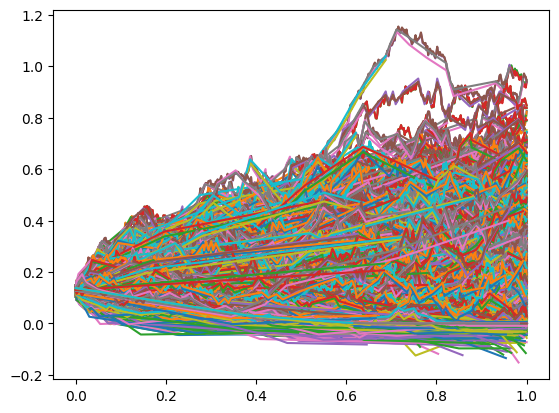

In [41]:
from tqdm import tqdm
for i in tqdm(range(number_of_paths), desc="Processing Paths"):
        t, X = simulate_GBM(T, n_steps, X0, sigma)
        _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta)
        tau_optimal = get_optimal_tau(X, alpha, eta)
        tau_ideal = list(range(len(t)))
        P_optimal = generate_observed_prices(X, tau_optimal, alpha)
        print(tau_optimal)
        error_1[i] = calculate_hedging_error(t, X, X, np.arange(len(t)), K, sigma)
        error_2[i] = calculate_hedging_error(t, X, P_fixed, tau_fixed, K, sigma, False)
        error_3[i] = calculate_hedging_error(t, X, P_optimal, tau_optimal, K, sigma, False)

In [31]:
print(error_1.mean())
print(error_2.mean())
print(error_3.mean())
print(error_1.std())
print(error_2.std())
print(error_3.std())

-0.0002604899295782598
-0.19968947927324038
0.009139394854510872
0.015768794577114432
0.08115354229077294
0.04882791775279602


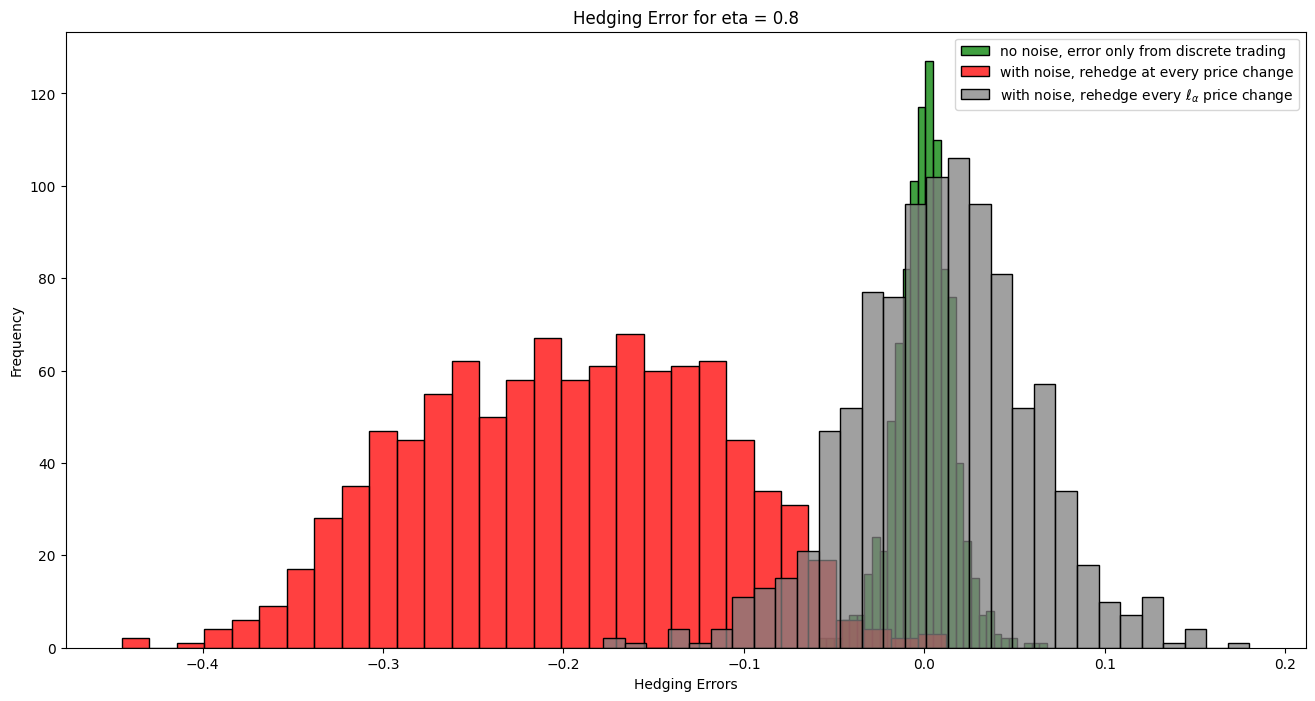

In [32]:
plt.figure(figsize=(16, 8))
sns.histplot(error_1, label = "no noise, error only from discrete trading", bins = 30, color = 'green',stat = 'count',legend=True)
sns.histplot(error_2, label = "with noise, rehedge at every price change", bins = 30, color = 'red',stat = 'count',legend=True)
sns.histplot(error_3, label = r"with noise, rehedge every $\ell_\alpha$ price change", bins = 30, color='grey',stat = 'count',legend=True)

plt.xlabel("Hedging Errors")
plt.ylabel("Frequency")
plt.title("Hedging Error for eta = 0.8")
plt.legend()
plt.savefig("hedgingError.pdf", format = "pdf")